## Solve geodesic equation given a metric, using FANTASY code

In this notebook I will be solving the geodesic equation for a given metric using a modified verison of the FANTASY code

### Imports

In [1]:
from FANTASY import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

#### Constants

In [2]:
G = c = M = 1
a = 0.2

## Define the metric

In [12]:
def g00(Param,Coord):
        
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    Delta = r**2.-2.*M*r+a**2.
    rhosq = r**2.+a**2.*cos(theta)**2.
    return -(r**2.+a**2.+2.*M*r*a**2.*sin(theta)**2./rhosq)/Delta

def g11(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    return (a**2.-2.*M*r+r**2.)/(r**2.+a**2.*cos(theta)**2.)


def g22(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    return 1./(r**2.+a**2.*cos(theta)**2.)
    
def g33(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    Delta = r**2.-2.*M*r+a**2.
    rhosq = r**2.+a**2.*cos(theta)**2.
    return (1./(Delta*sin(theta)**2.))*(1.-2.*M*r/rhosq)

# Off-diagonal components of the metric
def g01(Param,Coord):
    return 0

def g02(Param,Coord):
    return 0

def g03(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    Delta = r**2.-2.*M*r+a**2.
    rhosq = r**2.+a**2.*cos(theta)**2.
    return -(2.*M*r*a)/(rhosq*Delta)
    
def g12(Param,Coord):
    return 0

def g13(Param,Coord):
    return 0

def g23(Param,Coord):
    return 0


# Register the metrics as function in FANTASY
metric_list = ["g00","g01","g02","g03","g11","g12","g13","g22","g23","g33"]
for metric in metric_list:
    if metric in globals():
        register_function(metric, globals()[metric])
    else:
        print(f"No function named {metric} in global scope.")

## Plotting

In [13]:
def plot_trajectory(xs, ys, zs, params,title="Orbits", show=True, labels=["Kerr","Gravitomagnetism"]):
    # Plot the particle's orbit
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(xs)):
        ax.plot(xs[i],ys[i],zs[i], label=labels[i])

    # Label axes
    ax.set_xlim([-20, 20])
    ax.set_ylim([-20, 20])
    ax.set_zlim([-20, 20])
    ax.set_xlabel('x / Rs')
    ax.set_ylabel('y / Rs')
    ax.set_zlabel('z / Rs')
    ax.legend()
    plt.title(title)

    # Set false if want to continue working on plot
    if show:
        plt.show()
    else:
        return fig, ax

# Make animation of trajectory
def animate_traj(x, y, z, params, title="Kerr orbit", show=True):
    # Plot the particle's orbit
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    line,  = ax.plot([],[],[], color='black')

    def update_traj(frame, line):
        line.set_data(x[:frame],y[:frame])
        line.set_3d_properties(z[:frame])

        # return lines
        return line,

    # # Set plot limits and labels
    ax.set_xlim([-20, 20])
    ax.set_ylim([-20, 20])
    ax.set_zlim([-20, 20])
    ax.set_xlabel('x /GM/c^2')
    ax.set_ylabel('y /GM/c^2')
    ax.set_zlabel('z /GM/c^2')
    ax.set_title(title)

    # Create animation
    ani = animation.FuncAnimation(fig, update_traj, len(t), fargs=(line,), blit=True, repeat=True)

    if show:
        plt.show()

    return ani


## Run the simulation

In [14]:
N = 500
delta = 1e-2
omega = 1
q0 = [0,10,pi/2,np.pi/4]
p0 = [1.,0.,0.,0.]
Param = [M,a]
order = 4

sol = geodesic_integrator(N,delta,omega,q0,p0,Param,order)

# Get the position and momentum of the particle in the first phase space
sol = np.array(sol[1:])
qs = sol[:,0,:]
ps = sol[:,1,:]

'On iteration number 0 with delta 0.01'

## Redo the sim with another metric

### Write new metric

In [15]:
def phi(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    
    return - G * M / r

def A(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    
    return G/c * np.array([0., -a * M**2, 0.]) / r**3

# Define the metric
def g00(Param,Coord):
        
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]

    return -c**2 * (1 - 2 * phi(Param,Coord) / c**2)

def g11(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    
    return 1 + 2 * phi(Param,Coord) / c**2


def g22(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    
    return 1 + 2 * phi(Param,Coord) / c**2
    
def g33(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]

    return (1 + 2 * phi(Param,Coord) / c**2)

# Off-diagonal components of the metric
def g01(Param,Coord):
    return - 4/c * A(Param,Coord)[0]

def g02(Param,Coord):
    return -4/c * A(Param,Coord)[1]

def g03(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]

    return -4/c * A(Param,Coord)[2]
    
def g12(Param,Coord):
    return 0

def g13(Param,Coord):
    return 0

def g23(Param,Coord):
    return 0

# Register the metrics as function in FANTASY
metric_list = ["g00","g01","g02","g03","g11","g12","g13","g22","g23","g33"]
for metric in metric_list:
    if metric in globals():
        register_function(metric, globals()[metric])
    else:
        print(f"No function named {metric} in global scope.")

### Run the same simulation

In [16]:
# N = 5000
# delta = 1e-2
# omega = 1
# q0 = [0,30,pi/2,np.pi/4]
# p0 = [1,0.,0.0,0.0]
# Param = [M,a]
# order = 4

sol2 = geodesic_integrator(N,delta,omega,q0,p0,Param,order)

# Get the position and momentum of the particle in the first phase space
sol2 = np.array(sol2[1:])
qs2 = sol2[:,0,:]
ps2 = sol2[:,1,:]


'On iteration number 0 with delta 0.01'

## Plot results

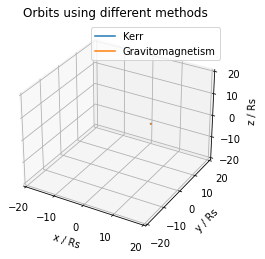

In [17]:
t, r, theta, phi = sol[:,0,0], sol[:,0,1], sol[:,0,2], sol[:,0,3]
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)


t, r, theta, phi = sol2[:,0,0], sol2[:,0,1], sol2[:,0,2], sol2[:,0,3]

x2 = r * np.sin(theta) * np.cos(phi)
y2 = r * np.sin(theta) * np.sin(phi)
z2 = r * np.cos(theta)

xs, ys, zs = [x,x2], [y,y2], [z,z2]


plot_trajectory(xs,ys,zs,Param, title="Orbits using different methods")

## Use gravitomagnetic 1.5PN metric for binary black holes

### Get orbit of standard circularized binaries

In [1]:
from FANTASY import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

G = c = M = 1
a = 0.2

In [2]:
# Assume cirular orbits a = - omega^2 x, with omega = v/r = sqrt(M/r^3)

r = 1.
omega = np.sqrt(M/r**3) # angular velocity, give higher order PN expansion later

N = 10
T = 2 * np.pi * omega
delta = T / N
t = np.linspace(0, T, N)


# Define trajectory of the two binaries
r1 = np.array([r * np.cos(omega * t), r * np.sin(omega * t), 0 * t]).T
r2 = np.array([r * np.cos(omega * t + np.pi), r * np.sin(omega * t + np.pi), 0 * t]).T

# Get velocities of the two binaries
v1 = np.array([-r * omega * np.sin(omega * t), r * omega * np.cos(omega * t), 0 * t]).T
v2 = np.array([-r * omega * np.sin(omega * t + np.pi), r * omega * np.cos(omega * t + np.pi), 0 * t]).T

# Calculate relative position and velocity of binaries
r12 = r1 - r2
n12 = r12 / r
R12 = np.linalg.norm(r12, axis=1)
v12 = v1 - v2
V12 = np.linalg.norm(v12, axis=1)

### Add new metric
From "Inspiralling, Non-Precessing, Spinning Black Hole Binary Spacetime
via Asymptotic Matching" - by Ireland et al. 2016

In [3]:
# Param = [r3, m1, m2, r1, r2, r12, v1, v2, v12, S1, S2]
# Coord = [t, x, y, z]

from numpy.linalg import norm as mag

def g00(Param,Coord):
        
    r3 = Param[0]                                               # Position vector of orbiting particle
    m1, m2, S1, S2 = Param[1], Param[2], Param[9], Param[10]    # Masses and spins of binary BHs
    r1, r2, r12 = Param[3], Param[4], Param[5]                  # Position vectors of binary BHs
    v1, v2, v12 = Param[6], Param[7], Param[8]                  # Velocities of binary BHs
    n12 = r12/mag(r12)                                          # Unit vector pointing from m1 to m2
    
    # r1 should actually be displacement from body 1 to particle
    r1 = r3 - r1
    r2 = r3 - r2
    n1, n2 = r1/mag(r1), r2/mag(r2)
    
    term1 = -1 + 2*m1/mag(r1) + 2*m2/mag(r2)  - 2*m1**2/mag(r2)**2 - 2* m2**2/mag(r1)**2
    term2 = m1/mag(r1) * (4*mag(v1)**2-np.dot(v1,v1)**2) + m2/mag(r2) * (4*mag(v2)**2-np.dot(v2,v2))
    term3a = -m1*m2*(2/(mag(r1)*mag(r2)) + mag(r1)/(2*mag(r12)**2)-mag(r1)**3 / (2*mag(r2)*mag(r12)**3)+ 5 / (2*mag(r1)*mag(r12)))
    term3b = -m2*m1*(2/(mag(r1)*mag(r2)) + mag(r2)/(2*mag(r12)**2)-mag(r2)**3 / (2*mag(r1)*mag(r12)**3)+ 5 / (2*mag(r1)*mag(r12)))
    term4 = 4*m1*m2/(3*mag(r12)**2) * np.dot(n12, v12) + 4*m2*m1/(3*mag(r12)**2) * np.dot(n12, v12)
    term5 = 4/mag(r1)**2 * np.dot(v1, np.cross(S1, n1)) + 4/mag(r2)**2 * np.dot(v2, np.cross(S2, n2))
    
    return term1 + term2 + term3a + term3b + term4 + term5


def g11(Param,Coord):
    r3 = Param[0]
    m1, m2 = Param[1], Param[2]
    r1, r2 = Param[3], Param[4]
    
    r1 = mag(r3 - r1)
    r2 = mag(r3 - r2)
    
    return (1 + 2*m1/r1 + 2*m2/r2)


def g22(Param,Coord):
    r3 = Param[0]
    m1, m2 = Param[1], Param[2]
    r1, r2 = Param[3], Param[4]
    
    r1 = mag(r3 - r1)
    r2 = mag(r3 - r2)
    
    return (1 + 2*m1/r1 + 2*m2/r2)
    
def g33(Param,Coord):
    r3 = Param[0]
    m1, m2 = Param[1], Param[2]
    r1, r2 = Param[3], Param[4]
    
    r1 = mag(r3 - r1)
    r2 = mag(r3 - r2)
    
    return (1 + 2*m1/r1 + 2*m2/r2)

# Off-diagonal components of the metric
def g01(Param,Coord):
    r3 = Param[0]
    m1, m2, S1, S2 = Param[1], Param[2], Param[9], Param[10]    # Masses and spins of binary BHs
    r1, r2, r12 = Param[3], Param[4], Param[5]                  # Position vectors of binary BHs
    v1, v2, v12 = Param[6], Param[7], Param[8]                  # Velocities of binary BHs
    r1 = r3 - r1
    r2 = r3 - r2
    n1, n2, n12 = r1/mag(r1), r2/mag(r2), r12/mag(r12)
    
    term1 = -4*m1/mag(r1) * v1[0] - 4*m2/mag(r2) * v1[0]
    term2 = -2/mag(r1)**2 * np.cross(S1, n1)[0] - 2/mag(r2)**2 * np.cross(S2, n2)[0]
    
    return term1 + term2
    
def g02(Param,Coord):
    r3 = Param[0]
    m1, m2, S1, S2 = Param[1], Param[2], Param[9], Param[10]    # Masses and spins of binary BHs
    r1, r2, r12 = Param[3], Param[4], Param[5]                  # Position vectors of binary BHs
    v1, v2, v12 = Param[6], Param[7], Param[8]                  # Velocities of binary BHs
    r1 = r3 - r1
    r2 = r3 - r2
    n1, n2, n12 = r1/mag(r1), r2/mag(r2), r12/mag(r12)

    
    term1 = -4*m1/mag(r1) * v1[1] - 4*m2/mag(r2) * v1[1]
    term2 = -2/mag(r1)**2 * np.cross(S1, n1)[1] - 2/mag(r2)**2 * np.cross(S2, n2)[1]
    
    return term1 + term2

def g03(Param,Coord):
    r3 = Param[0]
    m1, m2, S1, S2 = Param[1], Param[2], Param[9], Param[10]    # Masses and spins of binary BHs
    r1, r2, r12 = Param[3], Param[4], Param[5]                  # Position vectors of binary BHs
    v1, v2, v12 = Param[6], Param[7], Param[8]                  # Velocities of binary BHs
    r1 = r3 - r1
    r2 = r3 - r2
    n1, n2, n12 = r1/mag(r1), r2/mag(r2), r12/mag(r12)

    
    term1 = -4*m1/mag(r1) * v1[2] - 4*m2/mag(r2) * v1[2]
    term2 = -2/mag(r1)**2 * np.cross(S1, n1)[2] - 2/mag(r2)**2 * np.cross(S2, n2)[2]
    
    return term1 + term2
    
def g12(Param,Coord):
    return 0

def g13(Param,Coord):
    return 0

def g23(Param,Coord):
    return 0

# Register the metrics as function in FANTASY
metric_list = ["g00","g01","g02","g03","g11","g12","g13","g22","g23","g33"]
for metric in metric_list:
    if metric in globals():
        register_function(metric, globals()[metric])
    else:
        print(f"No function named {metric} in global scope.")


### Run simulation

In [8]:
order = 2

# Initial values - Coords = [t, x, y, z]
q0 = [0., 0.0, 0.0, 0.]
p0 = [1.0,0.0,0.0,0.0]

# Parameter values
r3_0 = q0[1:]
m1 = 0.5
m2 = M - m1
r1_0 = r1[0,:]
r2_0 = r2[0,:]
r12_0 = r12[0,:]
v1_0 = v1[0,:]
v2_0 = v2[0,:]
v12_0 = v12[0,:]
S1 = np.array([0.,0.,0.1])
S2 = np.array([0.,0.,0.1])

Param = [r3_0, m1, m2, r1_0, r2_0, r12_0, v1_0, v2_0, v12_0, S1, S2]

# Define function to update the parameters in "param"
def update_param(result, Param, index):
    
    # Update the position of the particle, based on integrators input
    r3 = result
        
    # Update the positions and velocities of binaries, based on stored array of values calculated beforehand
    r1 = r1[index, :]
    r2 = r2[index, :]
    r12 = r12[index, :]
    v1 = v1[index, :]
    v2 = v2[index, :]
    v12 = v12[index, :]
    
    # Update this infromation in the parameter array
    Param[0] = r3
    Param[3] = r1
    Param[4] = r2
    Param[5] = r12
    Param[6] = v1
    Param[7] = v2
    Param[8] = v12
    
    return Param
    
# Register this function, to allow FANTASY to update the parameters
register_function("update_param", globals()["update_param"])

# Make parameters accessible to FANTASY
Param_list = ["r3", "m1", "m2", "r1", "r2", "r12", "v1", "v2", "v12", "S1", "S2"]

for param in Param_list:
    register_parameter(param, globals()[param])

KeyError: 'r3'

In [1]:
# Run the simulation

sol = geodesic_integrator(N,delta,omega,q0,p0,Param,order,update_parameters=True)

# Get the position and momentum of the particle in the first phase space
sol = np.array(sol[1:])
qs = sol[:,0,:]
ps = sol[:,1,:]

x, y, z = qs[:,1], qs[:,2], qs[:,3]

NameError: name 'geodesic_integrator' is not defined

NameError: name 'x' is not defined

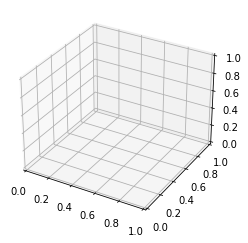

In [10]:
# 3D plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x,y,z, label="Particle")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")


ax.plot(r1[:,0], r1[:,1], r1[:,2], label='BH1', color="blue")
ax.plot(r2[:,0], r2[:,1], r2[:,2], label='BH2', color="red")

ax.legend()
ax.set_xlim(-2,2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)

plt.show()